# Table of contents
* [Chapter 1 - Introduction](#ch1)
* [Chapter 2 - Preprocessing](#ch2)
    * [Chapter 2.1 - Importing the libraries](#ch21)
    * [Chapter 2.2 - Description of the dataset](#ch22)
    * [Chapter 2.3 - Discretization](#ch23)
* [Chapter 3 - Data exploration](#ch3)
* [Chapter 4 - Naïve Bayes Network](#ch4)
    * [Chapter 4.1 - Considerations](#ch41)
* [Chapter 5 - Improving the Naïve Bayes network with Hill Climbing](#ch5)
* [Chapter 6 - Running Hill Climbing Unconstrained](#ch6)
    * [Chapter 6.1 - How Bayesian Networks are represented](#ch61)
    * [Chapter 6.2 - First run of the algorithm](#ch62)
    * [Chapter 6.3 - Adding a blacklist](#ch63)
    * [Chapter 6.4 - Manually adding edges to the network](#ch64)
* [Chapter 7 - Domain Knowledge Network](#ch7)
    * [Chapter 7.1 - Motivational Background](#ch71)
    * [Chapter 7.2 - Construction of the network](#ch72)
    * [Chapter 7.3 - Changing the estimator](#ch73)
* [Chapter 8 - Markov Blanket feature selection algorithm](#ch8)
* [Chapter 9 - Network analysis](#ch9)
* [Chapter 10 - Inference](#ch10)
    * [Chapter 10.1 - How the combinations of evidences affect the prediction](#ch101)
    * [Chapter 10.2 - Practical use of the model](#ch102)
* [Chapter 11 - Conclusion](#ch11)
    * [Chapter 11.1 - Whant's the best model](#ch111)
    * [Chapter 11.2 - What we have learned](#ch112)
    * [Chapter 11.3 - Future developments](#ch113)
* [Chapter 12 - References](#ch12)


    


<a class="anchor" id="top"></a>





# 1. Introduction
###### [Back to top](#top)
<a class="anchor" id="ch1"></a>

# Heart Disease Risk Assessment using Bayesian Networks

### Authors: Matteo Fasulo, Luca Tedeschini, Antonio Gravina, Luca babboni

### Course: Fundamentals of Artificial Intelligence and Knowledge Representation (Mod. 3) - Alma Mater Studiorum Università di Bologna

### Overview

**Cardiovascular diseases** (CVDs) are the number one cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 32% of all deaths worldwide. Four out of 5 CVD deaths are due to heart attacks and strokes, and one third of these deaths occur prematurely in people under 70 years of age [[1]](#1). 

The main risk factors for **heart disease** are unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol. The effects may include raised blood pressure, raised blood glucose, raised blood lipids, and overweight and obesity [[1]](#1). Since the 1930s, research has identified diverse **CVD risk factors** [[2]](#2). Notably, the World Health Organization categorizes factors as modifiable (influenced by lifestyle) and non-modifiable [[3]](#3). Interestingly, modifiable factors can be significantly impacted by individual choices and interventions. 

In this notebook, we will use a **Bayesian Network** to assess the **risk of heart disease** in a patient based on these risk factors. We will face the modelling of **causal relations** between the risk factors and the disease, and we will use the network to make **predictions** about the risk of heart disease in a patient. The aim is to learn a model which **given** the risk factors of a patient as input (**evidence**), can predict the probability of the patient having heart disease. The causal relations between the risk factors and the disease will be both learned from data and from **domain knowledge** found in the **literature** and in **medical guidelines**.

The work was inspired by a paper [[4]](#4) in which the authors used a Bayesian Network to assess the risk of heart disease in a patient. Their work guided us in the choice of the risk factors and in the structure of the network. However, we will use a different dataset and we will use a different approach to learn the parameters of the network.

---

# 2. Preprocessing
###### [Back to top](#top)

<a class="anchor" id="ch2"></a>

## 2.1 Importing the libraries
<a class="anchor" id="ch21"></a>

In [34]:
#os is used to access the csv file 
import os
#Warnings are used to ignore the warnings prompted by pgmpy
import warnings

#Itertools is used to create combinations on data structures
from itertools import combinations, product

#Pandas is used to work with dataframes
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

#PyImpetus is used to get the most important features
warnings.simplefilter(action='ignore', category=UserWarning)
from PyImpetus import PPIMBC

#Matplotlib and networkx are used to plot the graph
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np

#Pgmpy modules used throughout the code
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.readwrite import XMLBIFWriter

#Sklearn modules used throughout the code to work with the data
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

## 2.2 Description of the dataset
<a class="anchor" id="ch22"></a>

The original dataset [[5]](#5) was retrieved from **Kaggle**. The creator combined **5 heart disease datasets** on over **11 common features** commonly know to be strictly related to the prediction of possible heart disease. 

The dataset contains the following **attributes**:

* **Age**: age of the patient [years]

* **Sex**: sex of the patient
    * *M*: Male
    * *F*: Female
* **ChestPainType**: chest pain type 
    * *TA*: Typical Angina
    * *ATA*: Atypical Angina
    * *NAP*: Non-Anginal Pain
    * *ASY*: Asymptomatic
    
* **RestingBP**: resting blood pressure [mm Hg]

* **Cholesterol**: serum cholesterol [mm/dl]

* **FastingBS**: fasting blood sugar 
    * *1*: if FastingBS > 120 mg/dl
    * *0*: otherwise

* **RestingECG**: resting electrocardiogram results 
    * *Normal*: Normal
    * *ST*: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * *LVH*: showing probable or definite left ventricular hypertrophy by Estes' criteria

* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]

* **ExerciseAngina**: exercise-induced angina 
    * *Y*: Yes
    * *N*: No

* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]

* **ST_Slope**: the slope of the peak exercise ST segment 
    * *Up*: upsloping
    * *Flat*: flat
    * *Down*: downsloping
    
* **HeartDisease**: target variable 
    * *1*: heart disease
    * *0*: Normal


For the moment we consider these features *as they are*, but in the [Chapter 7](#ch7) we will provide **medical documentations** on how each feature influences (directly or indirectly) the target variable (i.e having an heart disease)

## 2.3 Discretization
<a class="anchor" id="ch23"></a>

Firstly, all the continuous variables are discretized using the `cut` function of the `pandas` library.

The discretization is performed in such a way to be as close as possible to the standard medical guidelines [[29]](#29) [[30]](#30); for example, the `RestingBP` (indicating the resting blood pressure) is discretized in 3 categories: `90-120`, `120-140` and `140+` according to the following intervals: $[90, 120]$, $(120, 140]$, $(140, +\infty)$.

The same procedure is done for the other continuous variables such as `Cholesterol` and `Oldpeak`.

We have also dropped some rows where the `Cholesterol` or the `RestingBP` are equal to $0$

In [2]:
def clean_data(data: pd.DataFrame):
    """
    Cleans the given DataFrame by performing various data transformations.

    Args:
        data (pd.DataFrame): The input DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame.

    """
    data = data[~(data['Cholesterol'] == 0) & ~(data['RestingBP'] == 0)]
    df = data.copy()
    df["Age"] = pd.cut(x=data["Age"], bins=[20, 40, 50, 60, 70, np.Inf], labels=[
        "20-40", "40-50", "50-60", "60-70", "70+"])

    df["RestingBP"] = pd.cut(x=data["RestingBP"], bins=[90, 120, 140, np.Inf], labels=[
        "90-120", "120-140", "140+"])

    df["Cholesterol"] = pd.cut(x=data["Cholesterol"], bins=[
        -np.Inf, 200, 240, np.Inf], labels=["<=200", "200-240", "240+"])

    df["MaxHR"] = pd.qcut(x=data["MaxHR"], q=4, labels=[
                          "low", "medium", "high", "very-high"])  # binning using quartiles

    df["Oldpeak"] = pd.cut(x=data["Oldpeak"], bins=[-np.Inf, 0.5, 1, 2, np.Inf], labels=[
        "<=0.5", "0-5-1", "1-2", "2+"])
    df['FastingBS'] = df['FastingBS'].map({0: 'N', 1: 'Y'})
    return df

In [3]:
data = pd.read_csv(f'data{os.sep}heart.csv')
df = clean_data(data)
df.to_csv(f'data{os.sep}heart_cleaned.csv')

print("The dataset contains %s observations and %s attributes" % df.shape)

df.head()

The dataset contains 746 observations and 12 attributes


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,20-40,M,ATA,120-140,240+,N,Normal,very-high,N,<=0.5,Up,0
1,40-50,F,NAP,140+,<=200,N,Normal,high,N,0-5-1,Flat,1
2,20-40,M,ATA,120-140,240+,N,ST,low,N,<=0.5,Up,0
3,40-50,F,ASY,120-140,200-240,N,Normal,low,Y,1-2,Flat,1
4,50-60,M,NAP,140+,<=200,N,Normal,low,N,<=0.5,Up,0


---

# 3. Data exploration
<a class="anchor" id="ch3"></a>
###### [Back to top](#top)


### Heart Disease Distribution in the Dataset

The dataset, after the preprocessing, contains 746 samples and 11 features plus the target variable.

The distribution of the target variable `HeartDisease` is shown in the following plot.

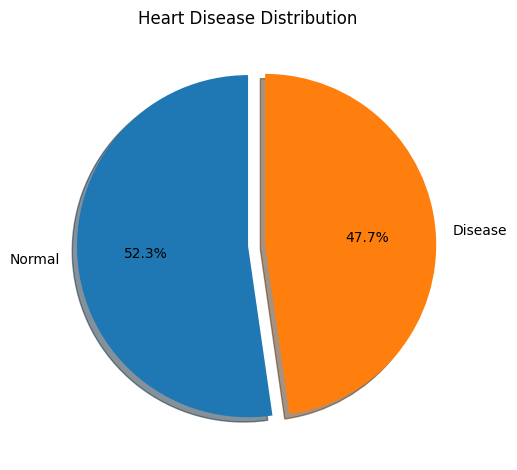

In [4]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[
    0, 0.1], shadow=True, labels=['Normal', 'Disease'], label='', title="Heart Disease Distribution")
plt.tight_layout()
plt.show()

The dataset is slightly imbalanced, with 390 samples of `HeartDisease` equal to 0 (Normal) and 356 samples of `HeartDisease` equal to 1 (affected with Heart Disease).


### Train-Test Split

We have split the dataset into `train` and `test` for the sake of evaluating our classificator.

The training set contains $85%$ of the samples, while the test set contains $15%$ of the samples and the split is performed using the `train_test_split` function of the `sklearn` library. Thanks to the `stratify` parameter of the procedure, we have mantained the same distribution of the target variable (`Heart disease`) in both the train and test set.

The training set will be used to learn the parameters of the Bayesian Network, while the test set will be used to evaluate the performance of the model in terms of accuracy and other metrics.

In [37]:
target_variable = "HeartDisease"
X, y = df.drop(columns=target_variable), df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

---

# 4. Naïve Bayes Network
<a class="anchor" id="ch4"></a>
###### [Back to top](#top)

A [Naïve Bayes classifier](https://www.ibm.com/topics/naive-bayes) is a specific type of **classifier** based on a Naïve Bayes network. It is characterized by its semplicity, and it is built upond a **simple assumption**: all the features are conditional independent if the target feature is given.

They are widely used in Machine Learning thanks to their **computational efficiency** and their **ease of implementation**. They can also be expanded with other connections, and we will see that using an **Hill Climbing** algorithm in the next chapter.

Creating a Naïve Bayes network in `pgmpy` is quite simple: once it is clear which are the features and which is the target variable, a simple list comprehension can build the network structure

In [92]:
network = [(target_variable, x) for x in df.columns[:-1]]
naive_bayes = BayesianNetwork(network)

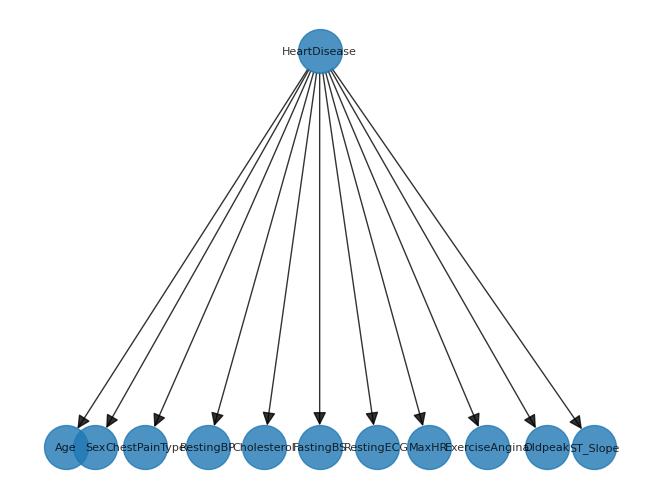

In [93]:
pos = nx.nx_agraph.graphviz_layout(naive_bayes, prog="dot")
nx.draw(naive_bayes, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

Once the structure of the network is built, the next step is to let it learn the parameters (_CPDs_) from the dataset. The choice is [between two algorithms](https://towardsdatascience.com/maximum-likelihood-vs-bayesian-estimation-dd2eb4dfda8a):

* **Maximum Likelihood Estimation**: Given the likelihood function $\mathcal{L}(\theta | D) = f(D | \theta) = \prod{}_{i=1}^{N}f(x_i | \theta)$, the MLE algorithm tries to fit the parameter $\theta$ that maximize the likelihood function:
$$ \hat{\theta} = \argmax_\theta \prod_{i=1}^N f(x_i | \theta) = \frac{\partial}{\partial \theta} \prod_{i=1}^N f(x_i|\theta)$$ 
Since computing the derivatives of many products can get really complex, in the real world it is used the _log likelihood function_. This is done because the logs of productus is the sum of the logs, and that's simplify the computation, and also the $\argmax$ of a function doens't change if we are applying the log, since it is strictly monotonic and scaled. So the real formula that is computed is
$$\text{log likelihood} : \int(\theta) = \ln \prod_{i=1}^Nf(x_i | \theta) = \sum_{i=1}^N \ln f(x_i | \theta)$$
Therefore,
$$ \hat{\theta} = \argmax_\theta \int (\theta)$$

This algorithm works the best if the dataset is big, since its outcome solely depends on the _observed_ data. It is also adviced when there is uncertainty about the prior.

* **Bayesian Estimation**: The equation used for Bayesian estimation is the following:
$$ \overbrace{\mathbb{P}(\theta | D)}^\text{posterior distribution} = \frac{\overbrace{\mathbb{P}(D|\theta)}^{\text{likelihood function}} \overbrace{\mathbb{P}(\theta)}^{\text{prior distribution}}}{\int \mathbb{P}(D|\theta) \mathbb{P}(\theta) d \theta}$$
the formula is quite similar to the *Bayes' theorem*, but instead of working with numerical value it uses models and pdfs. The Bayesian estimator tries to compute a distribution over the parameter space, called *posteriod pdf*, and denoted as $\mathbb{P}(\theta | D)$. This distribution represents how strongly we believe each parameter values is the one that generated our data, after taking into account both the observed data and the prior knowledge.

The bayesian estimations works the best if the priors of the networks *makes sense*.


Since we are working on a naïve network, the priors are probably not describing well how each feature affects each other, and we have proceeded using the **Maximum Likelihood Estimation**

To test the performance of the network, we have used `KFold` to compute an average of the `roc_auc` score given different **permutations** of the dataset, to get a more precise idea on the performances.

In [108]:
kfold = KFold(5, shuffle=True, random_state=42)

def bayesian_kfold(df, model, metric):
    score = []
    predictions = []
    for train, test in kfold.split(df):
        model.cpds = []
        model.fit(df.iloc[train, :], estimator=MaximumLikelihoodEstimator)
        y_pred = model.predict(df.drop(columns=target_variable, axis=1).iloc[test, :])
        score.append(
            metric(df[target_variable].iloc[test], y_pred[target_variable]))
        predictions.append(y_pred)
    return sum(score) / len(score), predictions[0]

In [109]:
%%capture
roc_auc_value, _ = bayesian_kfold(df, naive_bayesian, roc_auc_score)

In [110]:
print(f"The roc_auc score for the naive bayesian network is {roc_auc_value:.2f}")

The roc_auc score for the naive bayesian network is 0.84


## 4.1 Considerations
<a class="anchor" id="ch41"></a>
With the Naïve Bayesian classifier we get an overall good `roc_auc` score and we mantain a good computational performace. Is it possibile to improve the network? Does it make sense to add others **causal** link in between features?

---

# 5. Improving the Naïve Bayes network with Hill Climbing
<a class="anchor" id="ch5"></a>

The first approach we used to learn the structure of the Bayesian Network is the **Hill Climbing** algorithm.

The Hill Climbing algorithm is a greedy search algorithm which starts from an empty network (or an already built one) and adds or removes edges to maximize a score [[14]](#14). The score is usually the **Bayesian Information Criterion (BIC)**, which is a trade-off between the likelihood of the data and the complexity of the model. Since it is a *local search algorithm*, it strongly depends on the starting network, and there is a very high risk of being stuck on a local Maximum. To avoid this, the algorithm is usually run multiple times with different initializations and the best network is selected.

The Hill Climbing algorithm is implemented in the `pgmpy` library. We have compared different scoring method to see which one works the best with our dataset.

In [43]:
%%capture

scores = {} # Dictionary to store the roc_auc_score for each scoring method
networks = {} # Dictionary to store the network structure for each scoring method

for scoring in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    network = HillClimbSearch(df, use_cache=False).estimate(scoring_method=scoring)
    networks[scoring] = network    
    model = BayesianNetwork(network)
    scores[scoring], _ = bayesian_kfold(df, model, roc_auc_score)

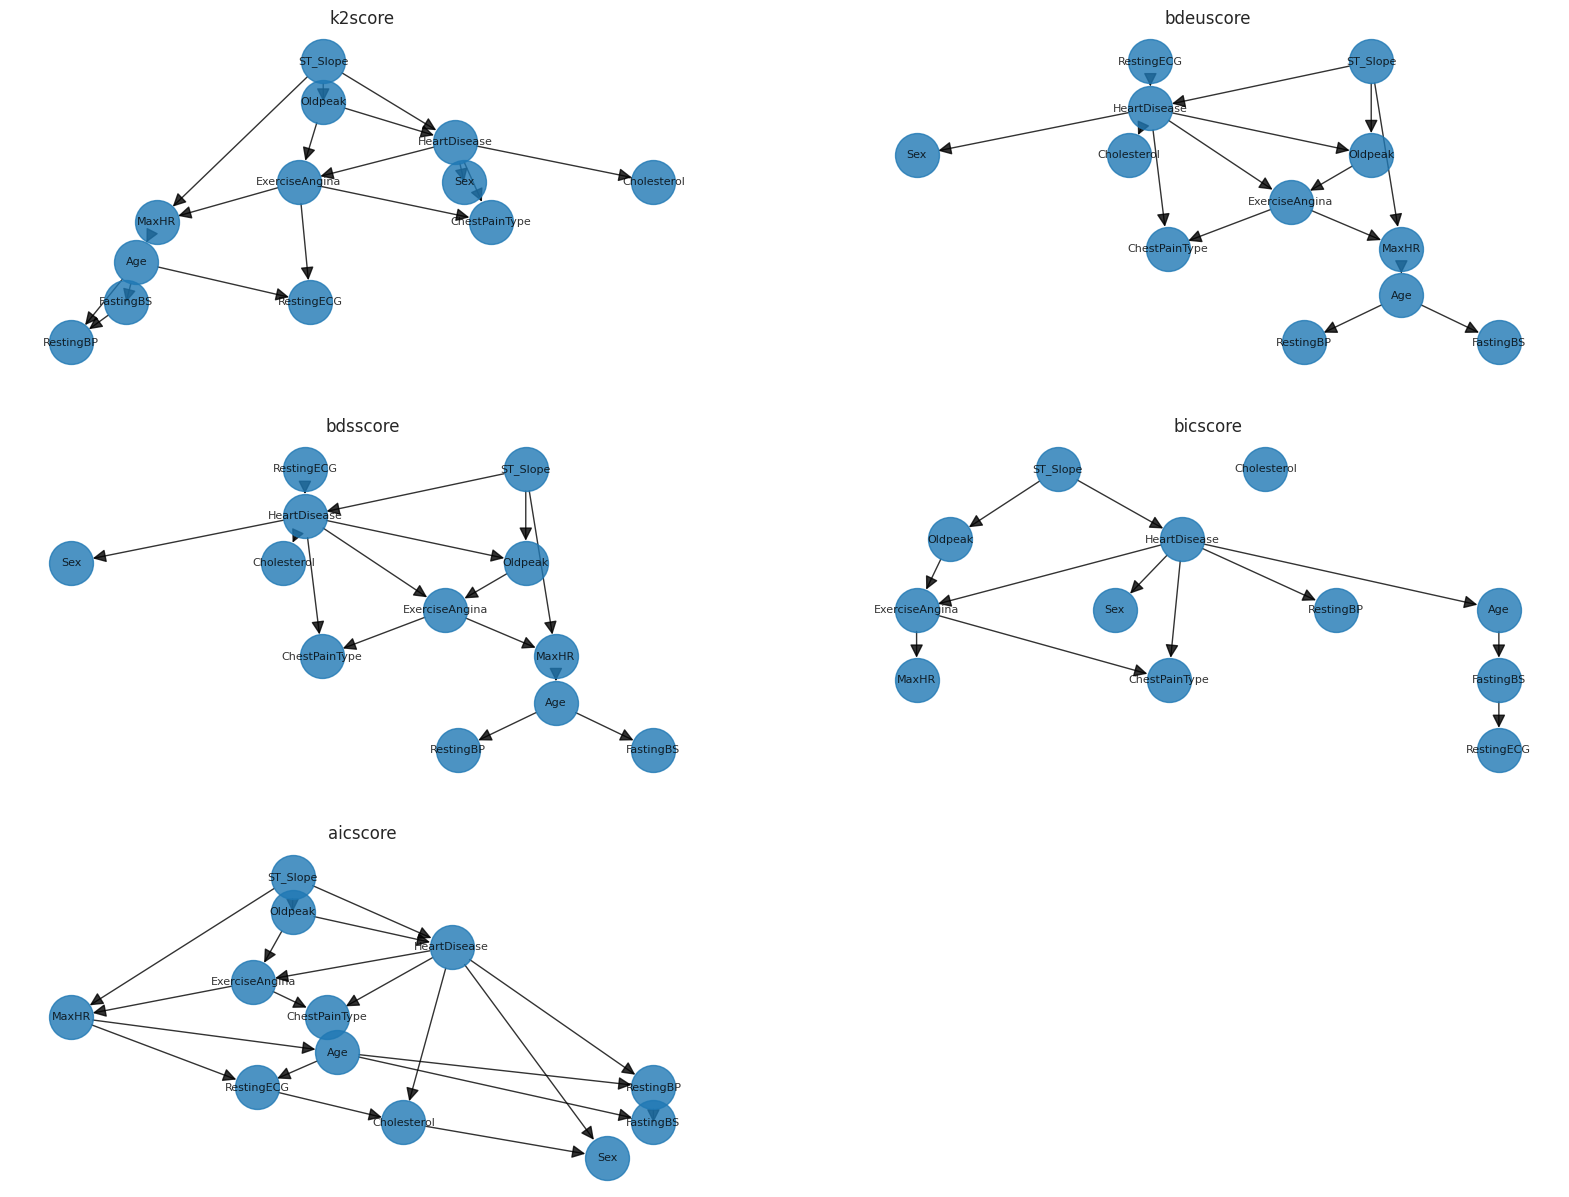

In [44]:
fig = plt.figure(figsize=(20,15))
i = 1
for scoring in networks:
    plt.subplot(3,2,i)
    pos = nx.nx_agraph.graphviz_layout(networks[scoring], prog="dot")
    nx.draw(networks[scoring], pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8) 
    plt.title(scoring) 
    i += 1
plt.show()

In [45]:
pd.DataFrame(scores, index = ['ROC AUC'])

,k2score,bdeuscore,bdsscore,bicscore,aicscore
ROC AUC,0.871053,0.864054,0.864054,0.853694,0.85557


The performance are slighly higher w.r.t the Naïve Bayesian Classifier, but the network doesn't have any clear semantic. For example, the nodes `Age` and `Sex` should not have parent nodes, because they are not influenced by any other feature (but it make sense that they influence other features). This means that Hill Climbing learns a structure that may even have good performance, but it does not have (in most cases) semantical correctness.

From the comparison of the scoring parameter of the Hill Climbing above one can notice that they have an overall similar `ROC AUC`. However, the networks are different from each other and each network is not fully explainable. This means that:
- the choice of the scoring method does not influence so much the performance, even if the structures of the networks are different
- since the semantic is problematic, we need to add some constraint through blacklisting/whitelisting. This means that the Hill Climbing will not explore the connections written in the blacklist while they will use the connections reported in the whitelist.

Given these consideration we can choose as the scoring method for the Hill Climbing the `bdeuscore`, since it has the best performance, and build an unconstraied network which we can improve manually.

---

# 6. Running Hill Climbing Unconstrained
<a class="anchor" id="ch6"></a>
###### [Back to top](#top)


## 6.1 How Bayesian Networks are represented
<a class="anchor" id="ch6"></a>

The libraries used in this notebook represents the bayesian network as a **Directed Acyclic Graph (DAG)**.

A DAG is a graph that has a **topological ordering**, which means that the edges are oriented: they have a starting node and a destination node. This is important because the edges in the Bayesian Network represent the causal relation between the variables: the edge goes from the cause to the effect

## 6.2 First run of the algorithm
<a class="anchor" id="ch62"></a>

In [46]:
%%capture

hc_unconst = HillClimbSearch(df, use_cache=False).estimate(scoring_method='bdeuscore')

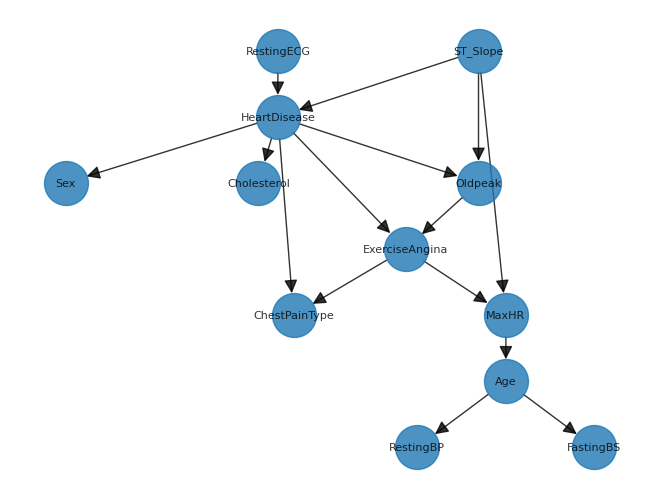

In [47]:
pos = nx.nx_agraph.graphviz_layout(hc_unconst, prog="dot")
nx.draw(hc_unconst, pos, with_labels=True, node_size=1000,
        font_size=8, arrowsize=20, alpha=0.8)

From the above plot, we can see that the structure of the Bayesian Network learnt from the data has some edges that are meaningless.

For example, the edges that points to `Age` and `Sex` does not make sense, because those features are not a consequence of other features, but it is valid the vice versa.

This is because the Hill Climbing algorithm is not aware of the domain knowledge and it tries to maximize the score by adding or removing edges. In the next section, we will use the domain knowledge to remove the edges that are not meaningful and to add the edges that are meaningful.

## 6.3 Adding a blacklist
<a class="anchor" id="ch63"></a>

In this section we will add a blacklist to the Hill Climbing algorithm that will limit the creation of unexplainable networks. The black list is passed as a parameter to the Hill Climbing algorithm.



In [48]:
black_list = [(target_variable, 'Cholesterol'), 
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR'),
              ('ExerciseAngina', 'Cholesterol'),
              ('ST_Slope', 'Oldpeak'),
              ('ExerciseAngina', 'RestingECG'),
              ('ExerciseAngina', 'ChestPainType')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [49]:
%%capture
hc_const = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

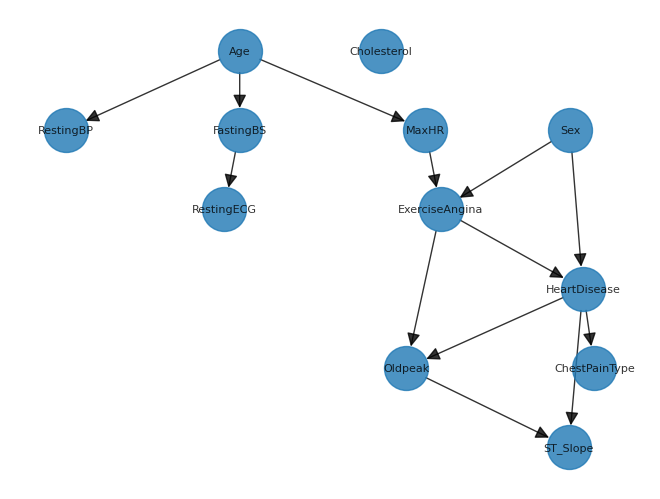

In [50]:
pos = nx.nx_agraph.graphviz_layout(hc_const, prog="dot")
nx.draw(hc_const, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

As we can see the new structure of the Bayesian Network still has some edges that are not meaningful.

Note that `Cholesterol` now is a singleton node, meaning that it is not connected to any other node. This is because the Hill Climbing algorithm removed the edge between `Cholesterol` and `HeartDisease` and there are no other edges that connect `Cholesterol` to the other nodes.

This is semantically wrong because `Cholesterol` is a risk factor for heart disease and it should be connected to the `HeartDisease` node, but this correlation was probably not captured by the algorithm while analyzing the data.

 We will use the references found in the literature and in the medical guidelines to adjust the edges.

## 6.4 Manually adding edges to the network
<a class="anchor" id="ch64"></a>

We are going to add some edges that make sense by referring medical documentation. The list is the following:
- Sex → Cholesterol [[7]](#7)
- Cholesterol → Heart Disease [[8]](#8)
- Oldpeak → ST_Slope [[9]](#9)
- RestingECG → Heart Disease [[9]](#9)
- RestingBP → Heart Disease [[10]](#10)
- Cholesterol → RestingBP [[11]](#11)
- FastingBS → Heart Disease [[12]](#12)
- Age → Cholesterol [[13]](#13)

In [51]:
hc_const.add_edge('Sex', 'Cholesterol')
hc_const.add_edge('Cholesterol', target_variable)
hc_const.add_edge('Oldpeak', 'ST_Slope')
hc_const.add_edge('RestingECG', target_variable)
hc_const.add_edge('RestingBP', target_variable)
hc_const.add_edge('Cholesterol', 'RestingBP')
hc_const.add_edge('FastingBS', target_variable)
hc_const.add_edge('Age', 'Cholesterol')

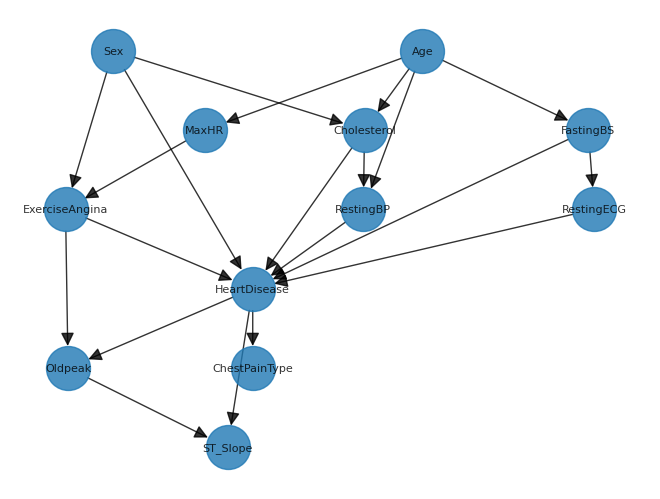

In [52]:
pos = nx.nx_agraph.graphviz_layout(hc_const, prog="dot")
nx.draw(hc_const, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

The structure now starts to have a more realistic semantic meaning but it is still not explainable due to the presence of some edges that are not meaningful. For example, the edge between `FatingBS` and `RestingECG` is meaningless because the two variables are not related to each other. 

Inferring the structure of the network from the data is not enough to obtain a meaningful one, we need to use domain knowledge to build a network that is semantically correct from scratch. In the next section we will do that.

> Just for comparison, here are the performance of this constrained network compared to the results. Firstly we need to convert the estimated DAG to a Bayesian Network and then we will learn the parameters of the network from the data using the `fit` method of the `BayesianNetwork` class using the `MaximumLikelihoodEstimator` as the estimator.

In [53]:
hc_const_model = BayesianNetwork(hc_const.edges())

In [54]:
%%capture
hc_const_model.cpds = [] # Clear the cpds
hc_const_model.fit(train, estimator=MaximumLikelihoodEstimator)
hc_const_model.get_cpds()
assert hc_const_model.check_model()

In [55]:
%%capture
accuracy, _ = bayesian_kfold(df, hc_const_model, accuracy_score)
roc_auc, _ = bayesian_kfold(df, hc_const_model, roc_auc_score)

In [56]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.831
ROC AUC: 0.830


---

# 7. Domain Knowledge Network
<a class="anchor" id="ch7"></a>
###### [Back to top](#top)

## 7.1 Motivational background
<a class="anchor" id="ch71"></a>

In this paragraph we will build a fully explainable network with the help of an expert in the field combined with the literature references reported in the section 11. The aim is to build a network that is fully explainable where each edge has a clear semantic meaning.

We have decided to pursue this direction because:

- Using a structure learning algorithm on this relatively small dataset could lead to overfitting. We have seen that in the sixth paragraph.
- In general we think that the people that partecipate in this kind of survey are not a good representation of the whole population (for example, there isn't even one underage person). In other words, we think that the dataframe could be biased by definition, and letting an algorithm learn on such biased dataset could lead to overfitting.
- Generally, a good `roc_auc` score is anything above 0.80[[31]](#31). We assume that the network we are going to build can easily achieve that score (since even the Naive Bayes one can get these kind of results), and even if it doesn't reach the score obtained before, it is fully explainable and more general, and it can be used in a real world scenario.
- Bayesian Networks are based on the conditional independence assumption: if some edge doesn't represent an actual causal-effect relation the whole structure may be weak

## 7.2 Construction of the network
<a class="anchor" id="ch72"></a>


The references for the Bayesian Network with Domain Knowledge are the following:

* Age → Cholesterol [[13]](#13)
* Age → RestingECG [[15]](#15)
* Age → MaxHR [[16]](#16)
* Age → RestingBP [[17]](#17)
* Age → FastingBS [[18]](#18)
* Age → HeartDisease [[19]](#19)
* Sex → Cholesterol [[7]](#7)
* Sex → MaxHR [[20]](#20)
* Sex → ExerciseAngina [[21]](#21)
* Sex → HeartDisease [[22]](#22)
* RestingECG → HeartDisease [[9]](#9)
* MaxGR → ExerciseAngina [[23]](#23)
* Cholesterol → HeartDisease [[24]](#24)
* Cholesterol → RestingBP [[25]](#25)
* RestingBP → FastinBS [[26]](#26)
* FastingBS → HeartDisease [[12]](#12)
* ExerciseAngina → HeartDisease [[27]](#27)
* ExerciseAngina → Oldpeak [[27]](#27)
* ExerciseAngina → ST_Slope [[27]](#27)
* HeartDisease → Oldpeak [[9]](#9)
* HeartDisease → ST_Slope [[9]](#9)
* HeartDisease → ChestPainType [[9]](#9)
* Oldpeak → ST_Slope [[9]](#9)

In [57]:
domain_kg_model = BayesianNetwork([
    ('Age', 'Cholesterol'),
    ('Age', 'RestingECG'),
    ('Age', 'MaxHR'),
    ('Age', 'RestingBP'),
    ('Age', 'FastingBS'),
    ('Age', target_variable),
    ('Sex', 'Cholesterol'),
    ('Sex', 'MaxHR'),
    ('Sex', 'ExerciseAngina'),
    ('Sex', target_variable),
    ('RestingECG', target_variable),
    ('MaxHR', 'ExerciseAngina'),
    ('Cholesterol', target_variable),
    ('Cholesterol', 'RestingBP'),
    ('RestingBP', 'FastingBS'),
    ('FastingBS', target_variable),
    ('ExerciseAngina', target_variable),
    ('ExerciseAngina', 'Oldpeak'),
    ('ExerciseAngina', 'ST_Slope'),
    (target_variable, 'Oldpeak'),
    (target_variable, 'ST_Slope'),
    (target_variable, 'ChestPainType'),
    ('Oldpeak', 'ST_Slope'),
]
)

After manually adding the edge, we get the following network.

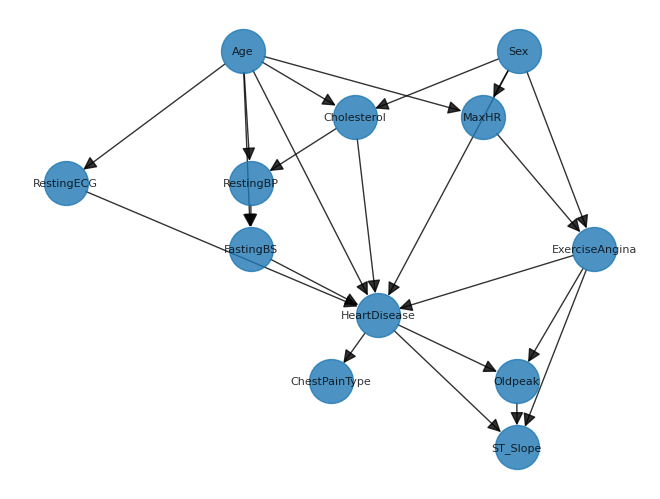

In [58]:
pos = nx.nx_agraph.graphviz_layout(domain_kg_model, prog="dot")
nx.draw(domain_kg_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

## 7.3 Changing the estimator
<a class="anchor" id="ch73"></a>


As stated in the paragraph 4, until now we have used the `MaximumLikelihoodEstimator` to estimate the CPDs of our networks since they lack semantic meaningfulness.

Now that we focus on the semantic correctness of the Bayesian Network, `BayesianEstimator` is a better choice, since it's used whene there is prior knowledge of the domain.

In [59]:
%%capture
domain_kg_model.cpds = []
domain_kg_model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
domain_kg_model.get_cpds()
assert domain_kg_model.check_model()

In [60]:
%%capture

accuracy, _ = bayesian_kfold(df, domain_kg_model, accuracy_score)
roc_auc, y_pred = bayesian_kfold(df, domain_kg_model, roc_auc_score)

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide


In [61]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.846
ROC AUC: 0.846


In [62]:
if not os.path.isdir('model'):
    os.mkdir('model')
domain_kg_model.save(f'model{os.sep}heart_disease_model.bif')
writer = XMLBIFWriter(domain_kg_model)
writer.write_xmlbif(f'model{os.sep}heart_disease_model.xml')

---

# 8. Markov Blanket feature selection algorithm

<a class="anchor" id="ch8"></a>
###### [Back to top](#top)

In this section we will use a Markov Blanket based feature selection algorithm that selects a subset of features by considering their performance both individually as well as a group. This allows the algorithm to not only select the best set of features, but also select the best set of features that play well with each other. The Markov Blanket of a node is the set of nodes that are conditionally independent of the node given the other nodes in the network. In other words, the Markov Blanket of a node is the set of nodes that are the parents, children, and parents of children of the node. The Markov Blanket of a node is the smallest set of nodes that contains all the information about the node. 

`PyImpetus` [[28]](#28) is a library that implements a Markov Blanket based feature selection algorithm. By first using a classifier to determine the features that are most important, and then using a Markov Blanket based feature selection algorithm to select the best set of features, we can create a network that is semantically correct and has the best performance.

First we need to encode the categorical variables using the `OrdinalEncoder` of the `sklearn` library (since for this task we need numeric values). Then we will use the `PyImpetus` library to select the best set of features. We will use the `SVC` as the classifier to determine the features that are most important. Then we will use the `MarkovBlanket` (MB) class of the `PyImpetus` library to select the best set of features.

In [67]:
encoder = OrdinalEncoder().set_output(transform='pandas')

X_enc, _ = encoder.fit_transform(X), y

Here the library is used to select the best set of features by means of a `SVC` classifier with fixed `random_state` (for reproducibility) and balanced `class_weight`. The algorithm needs also a `p_val_thresh` below which a feature will be considered as a candidate for the final MB, as well as a number of simulations (`num_simul`) and a simulation size (`simul_size`). 

* `simul_type` set to 1 means that the algorithm will use a stratify split to divide the dataset in training and test set, and it will use the training set to select the best features.
* `sig_test_type` instead, is the type of significance test to use which is either `non-parametric` or `parametric`. The parametric tests use a tail paired t-test to compare the performance of the features, while the non-parametric tests use the Wilcoxon test to compare the performance of the features.
* `cv` is the cross validation strategy to use. In this case a `StratifiedKFold` which is a stratified k-fold cross validation strategy. We put it to 7 so that each fold, which means each fold contains ~14.28% of data (we want it to be as close to 15% as possible).

In [115]:
model_mb = PPIMBC(model=SVC(random_state=42, class_weight="balanced"), p_val_thresh=0.05, num_simul=100,
               simul_size=0.20, simul_type=1, sig_test_type="non-parametric", cv=5, random_state=42, n_jobs=-1, verbose=0)

In [116]:
%%capture

model_mb.fit_transform(X_enc, y.values)

So the most important features are the following.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


The most important features are: ['ST_Slope', 'ChestPainType', 'Sex', 'ExerciseAngina', 'RestingECG', 'Oldpeak']


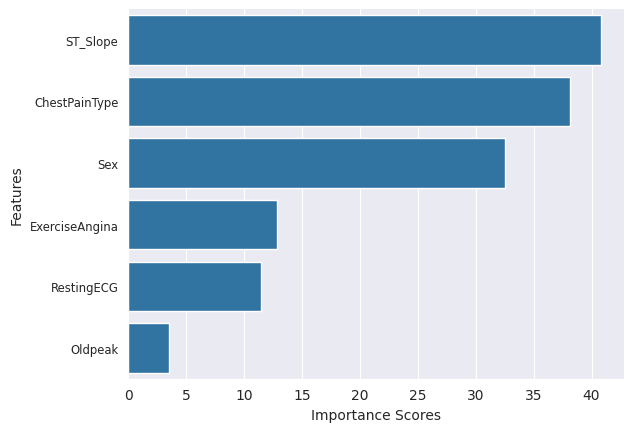

In [117]:
print(f"The most important features are: {model_mb.MB}")

model_mb.feature_importance()

Now we can use the variables selected by the Markov Blanket based feature selection algorithm to build a Bayesian Network that is semantically correct and has the best performance. We will start by taking all the edgs of the Domain Knowledge network and remove the ones that are not selected by the algorithm

In [118]:
all_nodes = model_mb.MB + [target_variable]
edges = [x for x in list(domain_kg_model.edges()) if x[0] in all_nodes and x[1] in all_nodes]

reduced_network = BayesianNetwork(edges)

In this way we can build a network that is semantically correct (since it is a subset of the edges of the previous network) and has the best performance (since it uses the best set of features).

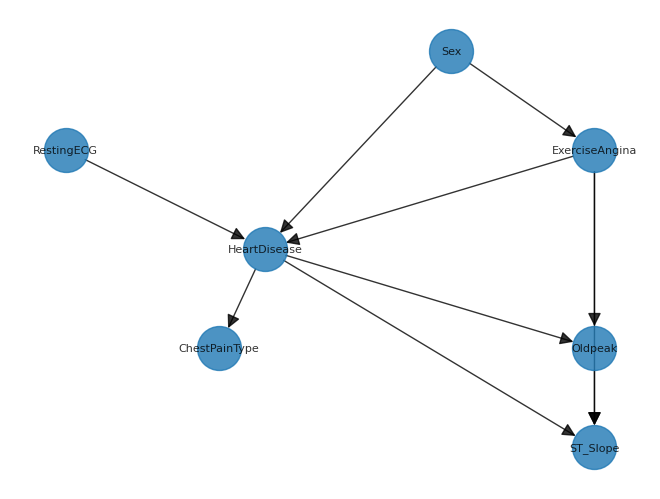

In [119]:
pos = nx.nx_agraph.graphviz_layout(reduced_network, prog="dot")
nx.draw(reduced_network, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

We notice that the network is way simpler than the others we built before.

We can then use the `fit` method of the `BayesianNetwork` class using the `BayesianEstimator` as the estimator to learn the parameters of the network from the data.

In [120]:
%%capture
reduced_network.cpds = []
reduced_network.fit(train[list(reduced_network.nodes)], estimator=BayesianEstimator, prior_type="BDeu")
reduced_network.get_cpds()
assert reduced_network.check_model()

In [121]:
removed_vars = list(reduced_network.nodes)
removed_vars.remove(target_variable)

And now we can make predictions about the risk of heart disease in a patient using the network by testing it on the test set with reduced dimensionality.

The network then can be compared in terms of `accuracy` and `ROC AUC` with the previous networks.

In [122]:
%%capture

accuracy, _ = bayesian_kfold(df.loc[:, list(reduced_network.nodes)], reduced_network, accuracy_score)
roc_auc, y_pred = bayesian_kfold(df.loc[:, list(reduced_network.nodes)], reduced_network, roc_auc_score)

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/pgmpy-0.1.24-py3.11.egg/pgmpy/factors/discrete/DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide


In [125]:
print(f'Accuarcy: {accuracy:.3f}')
print(f'ROC AUC: {roc_auc:.3f}')

Accuarcy: 0.854
ROC AUC: 0.855


As we can see the network built using the Markov Blanket based feature selection algorithm has the best performance in terms of `accuracy` and `ROC AUC`. This is because the algorithm selects the best set of features that play well with each other. The network is also semantically correct because it is a subset of the edges of the previous network. 

As a result, the network achieves 0.86 `ROC AUC` and 0.85 `accuracy` on the test set. However the network is too simplistic and it does not take into account the majority of the features. The features not included in the network may have complex interactions with the other features and may be important for the prediction of the risk of heart disease in a patient even if they are not selected by the algorithm.

**Thus the further analysis will be performed on the network built using the Domain Knowledge and not on the network built using the Markov Blanket based feature selection algorithm.**

---

# 9. Network analysis

<a class="anchor" id="ch9"></a>
###### [Back to top](#top)

Thanks to `pgmpy` it is possible to investigate several **properties of the network**. In particular the interent is to find the **conditional independencies** and **active trails** with respect to some given evidence or to ask for the **Markov Blanket** of a node. 

In [77]:
print(f'There can be made {len(domain_kg_model.get_independencies().get_assertions())}',
      'valid independence assertions with respect to the all possible given evidence.')
print('For instance, any node in the network is independent of its non-descendents given its parents:\n',
      f'\n{domain_kg_model.local_independencies(df.columns.tolist())}\n')

print('But we can also find some other independencies in the network given some evidence. For example:\n')

for node in df.columns.tolist():
    for assertion in domain_kg_model.get_independencies(latex=False, include_latents=True).get_assertions():
        if node in assertion.get_assertion()[0] and len(assertion.get_assertion()[2]) < 4 and len(assertion.get_assertion()[1]) < 3 and assertion not in domain_kg_model.local_independencies(df.columns.tolist()).get_assertions():
            print(assertion)
            break

There can be made 9885 valid independence assertions with respect to the all possible given evidence.
For instance, any node in the network is independent of its non-descendents given its parents:
 
(Age ⟂ Sex)
(Sex ⟂ Age, RestingECG)
(ChestPainType ⟂ ExerciseAngina, FastingBS, RestingECG, Cholesterol, RestingBP, Sex, Oldpeak, ST_Slope, MaxHR, Age | HeartDisease)
(RestingBP ⟂ ExerciseAngina, MaxHR, Sex, RestingECG | Age, Cholesterol)
(Cholesterol ⟂ ExerciseAngina, MaxHR, RestingECG | Age, Sex)
(FastingBS ⟂ ExerciseAngina, Sex, MaxHR, Cholesterol, RestingECG | Age, RestingBP)
(RestingECG ⟂ ExerciseAngina, RestingBP, Sex, MaxHR, FastingBS, Cholesterol | Age)
(MaxHR ⟂ FastingBS, RestingBP, RestingECG, Cholesterol | Age, Sex)
(ExerciseAngina ⟂ RestingBP, FastingBS, Cholesterol, Age, RestingECG | MaxHR, Sex)
(Oldpeak ⟂ FastingBS, RestingECG, Cholesterol, Sex, RestingBP, ChestPainType, MaxHR, Age | ExerciseAngina, HeartDisease)
(ST_Slope ⟂ FastingBS, Cholesterol, RestingECG, RestingBP, Sex, 

In [78]:
print('Thanks to this library it is also possible to find automatically the Markov blanket of any node in the network.\n')


def markov_blanket(model, target_variable):
    return f"Markov blanket of \'{target_variable}\' is {domain_kg_model.get_markov_blanket(target_variable)}"


for column in df.columns:
    print(markov_blanket(domain_kg_model, column))

Thanks to this library it is also possible to find automatically the Markov blanket of any node in the network.

Markov blanket of 'Age' is ['ExerciseAngina', 'FastingBS', 'HeartDisease', 'RestingECG', 'Cholesterol', 'RestingBP', 'Sex', 'MaxHR']
Markov blanket of 'Sex' is ['ExerciseAngina', 'FastingBS', 'HeartDisease', 'Cholesterol', 'RestingECG', 'MaxHR', 'Age']
Markov blanket of 'ChestPainType' is ['HeartDisease']
Markov blanket of 'RestingBP' is ['FastingBS', 'Age', 'Cholesterol']
Markov blanket of 'Cholesterol' is ['ExerciseAngina', 'FastingBS', 'HeartDisease', 'RestingECG', 'Sex', 'RestingBP', 'Age']
Markov blanket of 'FastingBS' is ['ExerciseAngina', 'HeartDisease', 'RestingECG', 'Cholesterol', 'Sex', 'RestingBP', 'Age']
Markov blanket of 'RestingECG' is ['ExerciseAngina', 'FastingBS', 'HeartDisease', 'Cholesterol', 'Sex', 'Age']
Markov blanket of 'MaxHR' is ['ExerciseAngina', 'Age', 'Sex']
Markov blanket of 'ExerciseAngina' is ['FastingBS', 'HeartDisease', 'MaxHR', 'RestingECG',

---

# 10. Inference


<a class="anchor" id="ch10"></a>
###### [Back to top](#top)

## 10.1 How the combinations of evidences affect the prediction

<a class="anchor" id="ch101"></a>


`pgmpy` also provides some methods to inference the model.

In the following chapter we are gonna inference the model in order to understand how the evidence affects the results of the models.

More specifically we are gonna explore how the following combination of evidences affects the prediction of the model:
- `Age` of the patient
- the combinations of `RestingBP` and `FastingBP` of the patient
- the combination of the `Cholesterol` and `Sex` of the patient

In [79]:
target = [target_variable]

def format_string(array):
    string = str(array[0])
    for item in array[1:]: 
        string += f', {item}'
    return string

def exact_inference(model, variables, evidence):
    inference = VariableElimination(model)
    result = inference.query(variables=variables, evidence=evidence)
    return result

def create_dictionary(df, columns):
    dictionary = {}
    for column in columns:
        dictionary[column] = df[column].unique().tolist()
    return dictionary

def get_all_combinations(dictionary):
    if len(dictionary) == 1:
        return [{list(dictionary.keys())[0]: value} for value in dictionary[list(dictionary.keys())[0]]]
    res = []
    for k1, k2 in combinations(dictionary.keys(), 2):
        for v1, v2 in product(dictionary[k1], dictionary[k2]):
            res.append({k1: v1, k2: v2})
    return res

def he_prob_analysis(model, target, knowledge, df):
    res = pd.DataFrame(columns=knowledge + ["Prob"]) 
    if len(knowledge) == 1:
        print(f'How does {format_string(knowledge)} affect the {format_string(target)} probability?')
    else:
        print(f'How the does combination of the variables {format_string(knowledge)} affect the {format_string(target)} probability?')

    all_values = create_dictionary(df, knowledge)
    all_queries = get_all_combinations(all_values)

    for query in all_queries:
        result = exact_inference(model, target, query)
        query["Prob"] = result.values[1]
        res.loc[len(res)] = query

    return res.sort_values(by=knowledge[0], ascending=False).reset_index(drop=True)

In [80]:
evidences = ["Age"]
he_prob_analysis(domain_kg_model, target, evidences, df)

How does Age affect the HeartDisease probability?


,Age,Prob
0,70+,0.618510
1,60-70,0.671738
2,50-60,0.453654
3,40-50,0.407760
4,20-40,0.299332


In [81]:
evidences = ['RestingBP', 'FastingBS']
he_prob_analysis(domain_kg_model, target, evidences, df)

How the does combination of the variables RestingBP, FastingBS affect the HeartDisease probability?


,RestingBP,FastingBS,Prob
0,90-120,N,0.430367
1,90-120,Y,0.490279
2,140+,N,0.501145
3,140+,Y,0.621003
4,120-140,N,0.449936
5,120-140,Y,0.547821


In [82]:
evidences =  ['Cholesterol', 'Sex']
he_prob_analysis(domain_kg_model, target, evidences, df)

How the does combination of the variables Cholesterol, Sex affect the HeartDisease probability?


,Cholesterol,Sex,Prob
0,<=200,M,0.471456
1,<=200,F,0.224809
2,240+,M,0.590717
3,240+,F,0.292656
4,200-240,M,0.521641
5,200-240,F,0.170678


In [83]:
evidences = ['ST_Slope', 'Oldpeak']
he_prob_analysis(domain_kg_model, target, evidences, df)

How the does combination of the variables ST_Slope, Oldpeak affect the HeartDisease probability?


,ST_Slope,Oldpeak,Prob
0,Up,<=0.5,0.080900
1,Up,0-5-1,0.324528
2,Up,1-2,0.319725
3,Up,2+,1.000000
4,Flat,<=0.5,0.740093
5,Flat,0-5-1,0.612591
6,Flat,1-2,0.793428
7,Flat,2+,0.943565
8,Down,<=0.5,0.000000
9,Down,0-5-1,0.533319


## 10.2 Practical use of the model

<a class="anchor" id="ch102"></a>


In this chapter, we delve into practical examples of interacting with the model. We explore various types of requests and how the model responds. Additionally, we introduce a new feature that dynamically suggests the next medical examination based on estimated heart health risks.

In [84]:
def prediction(model, query):
    labels = df.columns.tolist()
    labels.remove('HeartDisease')
    variables = []

    for label in labels:
        if label not in query.keys():
            variables.append(label)

    base_result = exact_inference(model, target, query)
    probs = base_result.values
    probs = np.round(probs * 100, 2)

    my_dict = {}
    for col in df.drop('HeartDisease', axis=1).columns:
        my_dict[col] = df[col].unique().tolist()
    exam_df = pd.DataFrame(columns=['exam', 'outcome', 'prob'])

    for var in variables:
        for val in my_dict[var]:
            query[var] = val
            result = exact_inference(model, target, query)
            exam_df.loc[len(exam_df)] = [var, val, round(result.values[1],2)]
            del query[var]

    exam_df.sort_values(by='prob', ascending=False,inplace=True)

    print(f'Given the evidence: ')
    for key, value in query.items():
        print(f'{key}: {value}')
    print()
    print(f'The probability of having a heart disease is {probs[1]}%')
    
    if probs[1] == 100:
            print(f'Exiting, probability has reached 100%')
            return

    print('The next exams suggested are:')
    display(exam_df.head(3))
    

In [85]:
query = {'Age': '20-40', 'Sex': 'M', 'ChestPainType' : 'ATA'}

prediction(domain_kg_model, query)
print('-'*20)

print('Now we are going to test the model with a new query adding the result of the suggested exams.')
query['Oldpeak'] = '2+'
prediction(domain_kg_model, query)
print('-'*20)

print('Now we are going to test the model with a new query adding the result of the suggested exams.')
query['ST_Slope'] = 'Up'
prediction(domain_kg_model, query)

Given the evidence: 
Age: 20-40
Sex: M
ChestPainType: ATA

The probability of having a heart disease is 7.43%
The next exams suggested are:


,exam,outcome,prob
20,Oldpeak,2+,0.51
16,ExerciseAngina,Y,0.25
22,ST_Slope,Flat,0.24


--------------------
Now we are going to test the model with a new query adding the result of the suggested exams.
Given the evidence: 
Age: 20-40
Sex: M
ChestPainType: ATA
Oldpeak: 2+

The probability of having a heart disease is 50.56%
The next exams suggested are:


,exam,outcome,prob
17,ST_Slope,Up,1.00
18,ST_Slope,Flat,0.64
3,Cholesterol,240+,0.63


--------------------
Now we are going to test the model with a new query adding the result of the suggested exams.
Given the evidence: 
Age: 20-40
Sex: M
ChestPainType: ATA
Oldpeak: 2+
ST_Slope: Up

The probability of having a heart disease is 100.0%
Exiting, probability has reached 100%


---

# 11. Conclusion

<a class="anchor" id="ch11"></a>
###### [Back to top](#top)

## 11.1. What's the best model?
<a class="anchor" id="ch111"></a>

As stated in the chapter 8.1, in the end we think that a fully explainable network is better than a network that has higher performance but doesn't make sense (in a semantically point of view) or it doesn't use all the feature. Because:
* All the features are related to the heart disease (ch. 8.2 and its references), and even if they bring into the network some *noise* we think that it is actually better than not considering them at all
* One could say that a smaller network performs better (computationally speaking) and it is easier to retrain, and that's correct, but since we are working with such a small dataset (so we don't have any memory problem) it's pointless to be constrained to such limitation when you could consider all the features in the dataset
* The `roc_auc` score of `0.85` of the final network is a really good score, and trying to improve that would probably lead to overfitting on the dataset

So we have chosen to keep the network created in the ch. 8, for all the reason stated above.

## 11.2. What we have learned
<a class="anchor" id="ch112"></a>


From this deep analysis into the Bayesian Network, Bayesian Classification and the Heart disease field we have learned that:
* Even a single edge of a Bayesian Network can change the results. It is very important to design the network with the help of a domain expert, or in their absence, by referincing trusted sources to explain why an edge has been added.
* Structure learning algorithms that work on the whole dataframe can create a network that performs really well on a given scoring system, but they tend to learn correlation when there is actually none. Maybe if we had worked with a bigger dataset those algorithms could have learnt an actual causal-correlation between features, but the medical field is well known, for privacy issues, to not have really big datasets.
* Medical field is a difficult one to work on without a domain expert. It is tough to fully know the problem and its implications, also because some correlations are subject of study, or even not proven. 


## 11.3. Future developments

<a class="anchor" id="ch113"></a>

### Dyanamic Bayesian Network
Introducing the concept of time into our network could be more useful to follow a patient for a longer period of time. It could also be interesting to embedd the network into an ecosystem of wereables and smartphone, to keep the users always updated on their heart healt, while keeping their privacy because everything would run locally.

### Hidden Markov Models (HMM) and Hidden Semi Markov Models (HSMM)
If we had repeated clinical analysis of the same patient over time, we could consider implementing Hidden Markov Models (HMM) or Hidden Semi Markov Models (HSMM). These models are suitable for analyzing sequential data and can capture the temporal dependencies in the patient's health condition.

HMMs are widely used in various fields, including speech recognition, natural language processing, and bioinformatics. They consist of a set of hidden states and observable symbols, with transition probabilities between states and emission probabilities for each symbol.

HSMMs are an extension of HMMs that allow for variable-length durations in each state. This can be useful in modeling clinical data where the duration of a particular health state may vary.

By incorporating HMM or HSMM into our Bayesian network, we can capture the dynamics of the patient's health condition over time and make more accurate predictions or assessments.

Implementing HMM or HSMM would require collecting longitudinal data from patients and training the models on this data. The models can then be used to predict future health states or assess the progression of a disease.


### Federated learning
Related to the last point, it would be really interesting to introduce some kind of federate learning. For example, every parameter gathered from the hypotethical wereables or by the doctors / people using the tool could be added in the Knowledge Base to increase the performance of the whole network.



---

# 12. References

<a class="anchor" id="ch12"></a>
###### [Back to top](#top)

<a id="1">[1]</a>
World Health Organization. (2024). Cardiovascular diseases (CVDs). <https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)>

<a id="2">[2]</a>
Mahmood, S. S., Levy, D., Vasan, R. S., & Wang, T. J. (2014). The Framingham Heart Study and the epidemiology of cardiovascular disease: a historical perspective. Lancet (London, England), 383(9921), 999–1008. <https://doi.org/10.1016/S0140-6736(13)61752-3>

<a id="3">[3]</a>
WHO CVD Risk Chart Working Group (2019). World Health Organization cardiovascular disease risk charts: revised models to estimate risk in 21 global regions. The Lancet. Global health, 7(10), e1332–e1345. <https://doi.org/10.1016/S2214-109X(19)30318-3>

<a id="4">[4]</a>
Ordovas, J.; Rios-Insua, D.; Santos-Lozano, A.; Lucia, A.; Torres, A.; Kosgodagan, A.; and Camacho, J. (2023). A bayesian network model for predicting cardiovascular risk. Computer Methods and Programs in Biomedicine. <https://doi.org/10.1016/j.cmpb.2023.107405>

<a id="5">[5]</a>
fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved March 2024 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

<a id="6">[6]</a>
Heckerman, D., Geiger, D. & Chickering, D.M. Learning Bayesian Networks: The Combination of Knowledge and Statistical Data. Machine Learning 20, 197–243 (1995). https://doi.org/10.1023/A:1022623210503

<a id="7">[7]</a>
Tharu BP, Tsokos CP. A Statistical Study of Serum Cholesterol Level by Gender and Race. J Res Health Sci. 2017; 17(3): e00386.

<a id="8">[8]</a>
Jung E, Kong SY, Ro YS, Ryu HH, Shin SD. Serum Cholesterol Levels and Risk of Cardiovascular Death: A Systematic Review and a Dose-Response Meta-Analysis of Prospective Cohort Studies. Int J Environ Res Public Health. 2022 Jul 6;19(14):8272. https://doi.org/10.3390/ijerph19148272. PMID: 35886124; PMCID: PMC9316578.

<a id="9">[9]</a>
Textbook of Cardiology contributors, "Chest Pain / Angina Pectoris," Textbook of Cardiology, , https://www.textbookofcardiology.org/index.php?title=Chest_Pain_/_Angina_Pectoris&oldid=2449

<a id="10">[10]</a>
Saxena A, Minton D, Lee DC, Sui X, Fayad R, Lavie CJ, Blair SN. Protective role of resting heart rate on all-cause and cardiovascular disease mortality. Mayo Clin Proc. 2013 Dec;88(12):1420-6. https://doi.org/10.1016/j.mayocp.2013.09.011. PMID: 24290115; PMCID: PMC3908776.

<a id="11">[11]</a>
Sakurai M, Stamler J, Miura K, Brown IJ, Nakagawa H, Elliott P, Ueshima H, Chan Q, Tzoulaki I, Dyer AR, Okayama A, Zhao L; INTERMAP Research Group. Relationship of dietary cholesterol to blood pressure: the INTERMAP study. J Hypertens. 2011 Feb;29(2):222-8. https://doi.org/10.1097/HJH.0b013e32834069a5. PMID: 21045731; PMCID: PMC3075799.

<a id="12">[12]</a>
Lee, G., Kim, S.M., Choi, S. et al. The effect of change in fasting glucose on the risk of myocardial infarction, stroke, and all-cause mortality: a nationwide cohort study. Cardiovasc Diabetol 17, 51 (2018). https://doi.org/10.1186/s12933-018-0694-z

<a id="13">[13]</a>
Jung HN, Kim MJ, Kim HS, Lee WJ, Min SH, Kim YJ, Jung CH. Age-Related Associations of Low-Density Lipoprotein Cholesterol and Atherosclerotic Cardiovascular Disease: A Nationwide Population-Based Cohort Study. J Am Heart Assoc. 2022 May 3;11(9):e024637. https://doi.org/10.1161/JAHA.121.024637. Epub 2022 May 2. PMID: 35492003; PMCID: PMC9238630.

<a id="14">[14]</a>
Kitson, N.K., Constantinou, A.C., Guo, Z. et al. A survey of Bayesian Network structure learning. Artif Intell Rev 56, 8721–8814 (2023). https://doi.org/10.1007/s10462-022-10351-w

<a id="15">[15]</a>
Khane RS, Surdi AD, Bhatkar RS. Changes in ECG pattern with advancing age. J Basic Clin Physiol Pharmacol. 2011 Sep 8;22(4):97-101. https://doi.org/10.1515/JBCPP.2011.017. PMID: 22865429.

<a id="16">[16]</a>
Hirofumi Tanaka, Kevin D Monahan, Douglas R Seals, Age-predicted maximal heart rate revisited, Journal of the American College of Cardiology, Volume 37, Issue 1, 2001, Pages 153-156, ISSN 0735-1097, https://doi.org/10.1016/S0735-1097(00)01054-8.

<a id="17">[17]</a>
Gurven M, Blackwell AD, Rodríguez DE, Stieglitz J, Kaplan H. Does blood pressure inevitably rise with age?: longitudinal evidence among forager-horticulturalists. Hypertension. 2012 Jul;60(1):25-33. https://doi.org/10.1161/HYPERTENSIONAHA.111.189100. Epub 2012 May 21. PMID: 22700319; PMCID: PMC3392307.

<a id="18">[18]</a>
Yi, SW., Park, S., Lee, Yh. et al. Association between fasting glucose and all-cause mortality according to sex and age: a prospective cohort study. Sci Rep 7, 8194 (2017). https://doi.org/10.1038/s41598-017-08498-6

<a id="19">[19]</a>
Rodgers JL, Jones J, Bolleddu SI, Vanthenapalli S, Rodgers LE, Shah K, Karia K, Panguluri SK. Cardiovascular Risks Associated with Gender and Aging. J Cardiovasc Dev Dis. 2019 Apr 27;6(2):19. https://doi.org/10.3390/jcdd6020019. PMID: 31035613; PMCID: PMC6616540.

<a id="20">[20]</a>
Nóra Sydó, Sahar S. Abdelmoneim, Sharon L. Mulvagh, Béla Merkely, Martha Gulati, Thomas G. Allison, Relationship Between Exercise Heart Rate and Age in Men vs Women, Mayo Clinic Proceedings, Volume 89, Issue 12, 2014, Pages 1664-1672, ISSN 0025-6196, https://doi.org/10.1016/j.mayocp.2014.08.018.

<a id="21">[21]</a>
Hemingway H, Langenberg C, Damant J, Frost C, Pyörälä K, Barrett-Connor E. Prevalence of angina in women versus men: a systematic review and meta-analysis of international variations across 31 countries. Circulation. 2008 Mar 25;117(12):1526-36. https://doi.org/10.1161/CIRCULATIONAHA.107.720953. Epub 2008 Mar 17. PMID: 18347213.

<a id="22">[22]</a>
Zujie Gao, Zengsheng Chen, Anqiang Sun, Xiaoyan Deng, Gender differences in cardiovascular disease, Medicine in Novel Technology and Devices, Volume 4, 2019, 100025, ISSN 2590-0935, https://doi.org/10.1016/j.medntd.2019.100025.

<a id="23">[23]</a>
Keteyian SJ, Kitzman D, Zannad F, Landzberg J, Arnold JM, Brubaker P, Brawner CA, Bensimhon D, Hellkamp AS, Ewald G. Predicting maximal HR in heart failure patients on β-blockade therapy. Med Sci Sports Exerc. 2012 Mar;44(3):371-6. https://doi.org/10.1249/MSS.0b013e318234316f. PMID: 21900844; PMCID: PMC3755356.

<a id="24">[24]</a>
Jousilahti P, Vartiainen E, Pekkanen J, Tuomilehto J, Sundvall J, Puska P. Serum cholesterol distribution and coronary heart disease risk: observations and predictions among middle-aged population in eastern Finland. Circulation. 1998 Mar 24;97(11):1087-94. https://doi.org/10.1161/01.cir.97.11.1087. PMID: 9531256.

<a id="25">[25]</a>
Ferrara LA, Guida L, Iannuzzi R, Celentano A, Lionello F. Serum cholesterol affects blood pressure regulation. J Hum Hypertens. 2002 May;16(5):337-43. https://doi.org/10.1038/sj.jhh.1001388. PMID: 12082495.

<a id="26">[26]</a>
Lv Y, Yao Y, Ye J, Guo X, Dou J, Shen L, Zhang A, Xue Z, Yu Y, Jin L. Association of Blood Pressure with Fasting Blood Glucose Levels in Northeast China: A Cross-Sectional Study. Sci Rep. 2018 May 21;8(1):7917. https://doi.org/10.1038/s41598-018-26323-6. PMID: 29784970; PMCID: PMC5962536.

<a id="27">[27]</a>
Hänninen H, Takala P, Mäkijärvi M, Korhonen P, Oikarinen L, Simelius K, Nenonen J, Katila T, Toivonen L. ST-segment level and slope in exercise-induced myocardial ischemia evaluated with body surface potential mapping. Am J Cardiol. 2001 Nov 15;88(10):1152-6. https://doi.org/10.1016/s0002-9149(01)02052-5. PMID: 11703962.

<a id="28">[28]</a>
Atif Hassan and Jiaul H. Paik and Swanand Khare and Syed Asif Hassan - PPFS: Predictive Permutation Feature Selection. 2021. https://doi.org/10.48550/arXiv.2110.10713

<a id=29>[29]</a>
Understanding Blood Pressure Readings - American Heart Association. https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

<a id=30>[30]</a>
Lipid Panel - hopkinsmedicine.org. https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/lipid-panel

<a id=31>[31]</a>
Jayawant N. Mandrekar, Receiver Operating Characteristic Curve in Diagnostic Test Assessment. Journal of Thoracic Oncology, Volume 5, Issue 9, 2010, Pages 1315-1316, ISSN 1556-0864, https://doi.org/10.1097/JTO.0b013e3181ec173d.